In [1]:
# Data source - https://drive.google.com/drive/folders/1oNfcFbLAlQF2TcImTr7ejr9ulueSx2Pj?usp=drive_link

In [3]:
! pip install keras-tuner

In [4]:
# Basic libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CNN libraries
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.preprocessing import image
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Metric Libraries
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# data directory path
train_dir = '/content/drive/MyDrive/Datasets/Input/Image_Classification/covid_xray_dataset/train'
test_dir = '/content/drive/MyDrive/Datasets/Input/Image_Classification/covid_xray_dataset/test'

In [22]:
# getting the training data

def create_df(data_path):

    file_path = []
    file_label = []

    for inst in os.listdir(data_path):
        f_path = os.path.join(data_path, inst)
        if os.path.isdir(f_path):
            images = os.listdir(f_path)
            for img in images:
                img_path = os.path.join(f_path, img)
                file_path.append(img_path)
                file_label.append(inst)

    file_series = pd.Series(file_path, name='FilePath')
    label_series = pd.Series(file_label, name='Labels')

    return pd.concat([file_series, label_series], axis=1)

In [23]:
# creating pandas serires for train and test data
train_df = create_df(train_dir)
test_df = create_df(test_dir)

In [24]:
# train data sample
train_df.head()

,FilePath,Labels
0,/content/drive/MyDrive/Datasets/Input/Image_Cl...,NORMAL
1,/content/drive/MyDrive/Datasets/Input/Image_Cl...,NORMAL
2,/content/drive/MyDrive/Datasets/Input/Image_Cl...,NORMAL
3,/content/drive/MyDrive/Datasets/Input/Image_Cl...,NORMAL
4,/content/drive/MyDrive/Datasets/Input/Image_Cl...,NORMAL


In [25]:
# test data sample
test_df.head()

,FilePath,Labels
0,/content/drive/MyDrive/Datasets/Input/Image_Cl...,NORMAL
1,/content/drive/MyDrive/Datasets/Input/Image_Cl...,NORMAL
2,/content/drive/MyDrive/Datasets/Input/Image_Cl...,NORMAL
3,/content/drive/MyDrive/Datasets/Input/Image_Cl...,NORMAL
4,/content/drive/MyDrive/Datasets/Input/Image_Cl...,NORMAL


In [29]:
# read a file path
train_df['FilePath'][0]

'/content/drive/MyDrive/Datasets/Input/Image_Classification/covid_xray_dataset/train/NORMAL/IM-0006-0001.jpeg'

In [30]:
# creating syn data by a data agumentation
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [31]:
train_df.head()

,FilePath,Labels
0,/content/drive/MyDrive/Datasets/Input/Image_Cl...,NORMAL
1,/content/drive/MyDrive/Datasets/Input/Image_Cl...,NORMAL
2,/content/drive/MyDrive/Datasets/Input/Image_Cl...,NORMAL
3,/content/drive/MyDrive/Datasets/Input/Image_Cl...,NORMAL
4,/content/drive/MyDrive/Datasets/Input/Image_Cl...,NORMAL


In [34]:
# data generator

# training
train_generator = train_datagen.flow_from_dataframe(
                    dataframe = train_df,
                    x_col = 'FilePath',
                    y_col = 'Labels',
                    target_size = (224, 224),
                    batch_size = 32,
                    class_mode = 'categorical',
                    shuffle = True,
                    seed = 42)

# testing
test_generator = test_datagen.flow_from_dataframe(
                    dataframe = test_df,
                    x_col = 'FilePath',
                    y_col = 'Labels',
                    target_size = (224, 224),
                    batch_size = 32,
                    class_mode = 'categorical',
                    shuffle = False)

Found 148 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.


In [35]:
# CNN architecture

def build_model(hp):
    model = Sequential([
        Conv2D(filters = hp.Int('con1_filter', min_value=32, max_value=128, step=8),
               kernel_size = hp.Choice('con1_kernel', values=[3,4,5,6,7]),
               activation = hp.Choice('con1_activation', ['relu', 'tanh']),
               input_shape = (224, 224, 3)),
        MaxPooling2D((2, 2)),

        Conv2D(filters = hp.Int('con2_filter', min_value=32, max_value=68, step=8),
               kernel_size = hp.Choice('con2_kernel', values=[2,3,4]),
               activation = hp.Choice('con2_activation', ['relu', 'tanh']),
               padding = 'same'),
        MaxPooling2D((2, 2)),

        Conv2D(filters = hp.Int('con3_filter', min_value=32, max_value=68, step=8),
               kernel_size = hp.Choice('con3_kernel', values=[2,3,4]),
               activation = hp.Choice('con3_activation', ['relu', 'tanh']),
               padding = 'same'),
        MaxPooling2D((2, 2)),

        Flatten(),

        Dense(units=hp.Int('dense1_units', min_value=120, max_value=256, step=8),
              activation = 'relu'),
        Dense(units=hp.Int('dense2_units', min_value=60, max_value=120, step=8),
              activation = 'relu'),
        Dense(2, activation='sigmoid')
    ])

    # model compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [36]:
# Tuner for the function
tuner = RandomSearch(hypermodel = build_model,
                     objective = 'accuracy',
                     max_trials = 5,
                     project_name = 'Pneumonia_Prediction')

In [37]:
# using the tuner to search hyper parameters with image datagenerator
tuner.search(train_generator, epochs=5, batch_size=32, validation_data=test_generator)

Trial 5 Complete [00h 00m 52s]
accuracy: 0.6891891956329346

Best accuracy So Far: 0.7364864945411682
Total elapsed time: 00h 07m 08s


In [39]:
# best model from the tuner
best_model = tuner.get_best_models(num_models=1)[0]

# summary of the best model
best_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 221, 221, 56)   │         2,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 56)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 110, 110, 40)   │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 55, 55, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 55, 55, 40)     │         6,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 27, 27, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 29160)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │     3,499,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 68)             │         8,228 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           138 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,537,070 (13.49 MB)

 Trainable params: 3,537,070 (13.49 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
tuner.results_summary()

Results summary
Results in ./Pneumonia_Prediction
Showing 10 best trials
Objective(name="accuracy", direction="max")

Trial 3 summary
Hyperparameters:
con1_filter: 56
con1_kernel: 4
con1_activation: tanh
con2_filter: 40
con2_kernel: 3
con2_activation: relu
con3_filter: 40
con3_kernel: 2
con3_activation: tanh
dense1_units: 120
dense2_units: 68
Score: 0.7364864945411682

Trial 0 summary
Hyperparameters:
con1_filter: 104
con1_kernel: 3
con1_activation: tanh
con2_filter: 56
con2_kernel: 3
con2_activation: tanh
con3_filter: 40
con3_kernel: 2
con3_activation: tanh
dense1_units: 176
dense2_units: 60
Score: 0.6959459185600281

Trial 4 summary
Hyperparameters:
con1_filter: 112
con1_kernel: 3
con1_activation: relu
con2_filter: 32
con2_kernel: 4
con2_activation: relu
con3_filter: 56
con3_kernel: 4
con3_activation: tanh
dense1_units: 240
dense2_units: 84
Score: 0.6891891956329346

Trial 2 summary
Hyperparameters:
con1_filter: 96
con1_kernel: 7
con1_activation: relu
con2_filter: 48
con2_kernel: 4
c

In [41]:
# fitting the data to the best model
best_model.fit(train_generator, epochs=10)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 949ms/step - accuracy: 0.6178 - loss: 1.0356
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6011 - loss: 0.6688
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 964ms/step - accuracy: 0.6652 - loss: 0.6157
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7673 - loss: 0.5185
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 903ms/step - accuracy: 0.8491 - loss: 0.4096
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8284 - loss: 0.4170
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 848ms/step - accuracy: 0.7320 - loss: 0.5250
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7459 - loss: 0.4097
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 948ms/step - accuracy: 0.8045 - loss: 0.4406
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8239 - loss: 0.4108   


In [42]:
# prediction accuracy
scores = best_model.evaluate(test_generator)
print(scores)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 606ms/step - accuracy: 0.9729 - loss: 0.1216
[0.11693950742483139, 0.9750000238418579]


In [43]:
# predictions
y_pred = best_model.predict(test_generator)
y_pred_class = np.argmax(y_pred, axis=1)
true_class = test_generator.classes

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step


Classification Report:

               precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.95      1.00      0.98        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



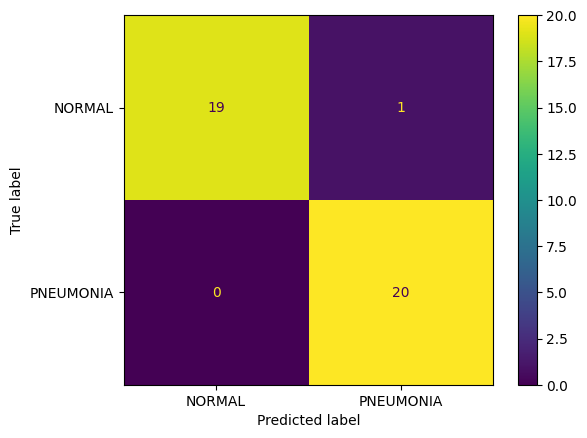

In [44]:
# metrics
cm = ConfusionMatrixDisplay.from_predictions(true_class, y_pred_class, display_labels=test_generator.class_indices)
print('Classification Report:\n\n', classification_report(true_class, y_pred_class))

In [65]:
# Random Validation

def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0      # img_array = image_arr/255.0
    return img_array

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step


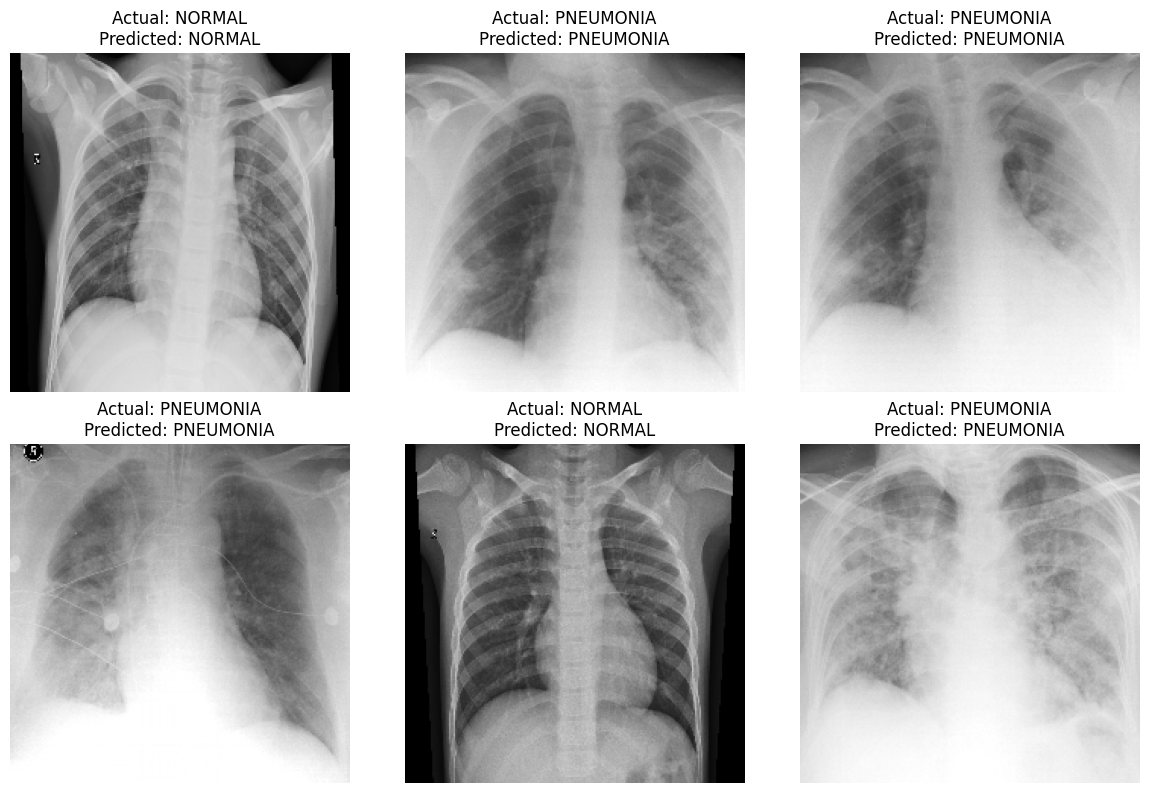

In [69]:
# predictions for the random images
random_indices = random.sample(range(len(test_df)), 6)
random_images_path = test_df.iloc[random_indices]['FilePath'].tolist()
random_images_labels = test_df.iloc[random_indices]['Labels'].to_list()

images = [load_and_preprocess_image(img_path) for img_path in random_images_path]
images = np.vstack(images)

# predictions for the images
predictions = best_model.predict(images)
predicted_classes = predictions.argmax(axis=1)

class_labels = {v:k for k, v in train_generator.class_indices.items()}
predicted_labels = [class_labels[idx] for idx in predicted_classes]

# plot figure for the predicitons
plt.figure(figsize=(12, 8))
for i, (img_path, actual_label) in enumerate(zip(random_images_path, random_images_labels)):
    img = image.load_img(img_path, target_size=(224, 224))
    plt.subplot(2, 3, i+1)
    plt.title(f'Actual: {actual_label}\nPredicted: {predicted_labels[i]}')
    plt.axis('off')
    plt.imshow(img)
plt.tight_layout()
plt.show()